## Fast Fourier Transform

The Discrete Fourier transform is slow. If sample points $y_n$ are assumed to be real, we need up to $(N/2)+1$ coefficients, that are each sum of $N$ terms. Thus, constructing the entire Fourier transform boils down to $((N/2)+1)N\sim\mathcal{O}(N^2/2)$ operations.  

The fast fourier transform is a simple trick introduced by Carl Friedrich Gauss in 1805. A Fourier coefficient 
$$
c_k = \sum_{n=0}^{N-1} y_n \exp\left(-i\frac{2\pi kn}{N}\right)
$$
can be written as sum of even and odd terms, where the even sum is,
$$ E_k = \sum_{r=0}^{(N/2)-1} y_{2r} \exp\left(-i\frac{2\pi k(2r)}{N}\right) = \sum_{r=0}^{(N/2)-1} y_{2r} \exp\left(-i\frac{2\pi k r}{(N/2)}\right) $$
which is another Fourier sum, with half the number of sample points, and the odd sum is,
$$ \sum_{r=0}^{(N/2)-1} y_{2r+1} \exp\left(-i\frac{2\pi k(2r+1)}{N}\right) = e^{-i2\pi k/N}\sum_{r=0}^{(N/2)-1} y_{2r+1} \exp\left(-i\frac{2\pi k r}{(N/2)}\right) = e^{-i2\pi k/N} O_k$$
which is another Fourier sum, with half the number of sample points, multiplied by a *twiddle factor*. This process of halving the sum is repeated until we end up with sample points $N=1$, that is, the sample point is its own Fourier coefficient. Each coefficients are then collected in pairs, 4s, 8s and so on, until we obtain the entire Fourier transform.

The above step, generalized to the mth step gives us
$$ E_k^{(m,j)} = E_k^{(m+1,j)} + e^{-i2\pi2^mk/N}E_k^{(m+1,j+2^m)} $$
starting at the last level, $m=\log_2N$, and repeatedly calculating $E_k^{(m,j)}$ for all $j$ and $k$, until we get down to $m=0$, which gives the full Fourier transform (see section 7.4.1 for the full derivation). 

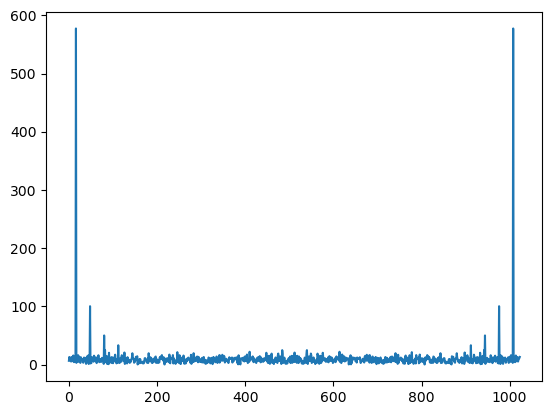

In [29]:
import numpy as np
import matplotlib.pyplot as plt

class E_wrap:
    def __init__(self, N):
        self.array = np.zeros((1+int(np.log2(N)),N),complex)
        self.N = N

    def __getitem__(self, indices):
        m, j, k = indices
        k %= self.N/2**m
        k = int(k)
        return self.array[m,j+2**m*k]

    def __setitem__(self, indices, value):
        m, j, k = indices
        k %= self.N/2**m
        k = int(k)
        self.array[m, j+2**m*k] = value

def fft(y):
    N = len(y)
    E = E_wrap(N)
    E.array[-1,:] = y

    for m in range(int(np.log2(N))-1,-1,-1):
        for j in range(2**m):
            for k in range(N//2**m):
                E[m,j,k] = E[m+1,j,k] + np.exp(-2j*np.pi*k/(N/2**m))*E[m+1,j+2**m,k]
    return E.array[0,:]

y = np.loadtxt('pitch.txt')
c = fft(y)
plt.plot(abs(c))

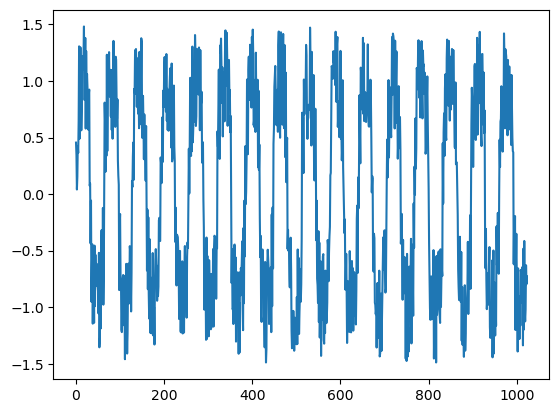

In [34]:
plt.plot(np.fft.ifft(c))

## Spectral Method

An alternative to (possibly unstable) finite difference methods of solving partial differential equations is the spectral method. However, this method can only be applied to problems where the boundary condition is well-behaved. Consider the wave equation 
$$ \frac{\partial^2 \phi}{\partial t^2} = v^2 \frac{\partial^2 \phi}{\partial x^2} $$
whose general solution is given by
$$ \phi_k(x,t) = \sin\left(\frac{\pi k x}{L}\right) e^{i\omega t} $$
where $\omega = \pi vk/L$. The string can be divided into $N$ equal intervals, with $N+1$ grid points, with the points at the end, having $\phi=0$, and the position of points $x_n = n(L/N)$. The general solution for a homogeneous linear differential equation can be written as
$$ \phi (x_n,t) = \frac{1}{N} \sum_{k=1}^{N-1} b_k \sin\left(\frac{\pi k x}{L}\right) \exp\left(i\frac{\pi kv t}{L}\right) $$
where $b_k=\alpha+i\eta_k$ is the complex coefficient, and the factor $(1/N)$ appears due to convention.   
At $t=0$, this takes the form
$$ \phi(x_n,0) = \frac{1}{N}\sum_{k=1}^{N-1}b_k\sin\left(\frac{\pi k n}{N}\right) $$
The real part of the solution corresponds to the initial state of $\phi$:
$$ \phi(x_n,0) = \frac{1}{N} \sum_{k=1}^{N-1}\alpha_k \sin\left(\frac{\pi k n}{N}\right) $$
Thus, **$\alpha_k$, the real part of $b_k$**, is the Fourier transform of initial state $\phi(x_n,0)$.  
Similarly, the time derivative of the real part of the solution at $t=0$ is
$$ \frac{\partial\phi}{\partial t} = - \left(\frac{\pi v}{L}\right)\frac{1}{N}\sum_{k=1}^{N-1}k\eta_k\sin\left(\frac{\pi kn}{N}\right) $$
Thus, **$\eta_k$, the imaginary part of $b_k$**, is the Fourier transform of the initial time derivative of $\phi(x_n,0)$, $|\partial\phi/\partial t|_{(x_n,0)}$ (with an additional factor of $\omega\equiv\omega(k)$).    
The general solution can then be re-written as
$$ \phi(x_n,t) = \frac{1}{N}\sum_{k=1}^{N-1} \left[\alpha_k\cos\left(\frac{\pi vkt}{L}\right) -\eta_k\sin\left(\frac{\pi vkt}{L}\right)\right] \sin\left(\frac{\pi kn}{N}\right) $$
Thus, **the inverse Fourier transform of the term within the square brackets gives the general solution at any $t$**! No need to integrate, hence, no question of instability.

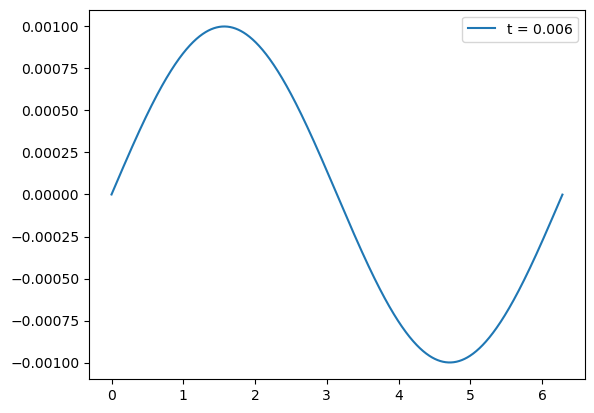

In [87]:
import numpy as np
import matplotlib.pyplot as plt

v    = 0.5
L    = 2*np.pi
N    = 1000 # Grid slices

a = L/N

# take a complex argument and split it into real and imaginary parts
def complex_arg(trans):
    def f(y):
    	return trans(np.real(y)) + 1j*trans(np.imag(y))
    return f

######################################################################
# 1D inverse DST Type-I

@complex_arg   # decorator, calls the function complex_arg(trans) before dst(y) is executed
def dst(y):
    N = len(y)
    y2 = np.empty(2*N,float)   # creating a copy array that would make y anti-symmetric for sine transform
    y2[0] = y2[N] = 0.0        # boundary condition
    y2[1:N] = y[1:]            # copy the sample as is for the first half
    y2[:N:-1] = -y[1:]         # the second half is just negative of first half (anitsymmetric)
    a = -np.imag(np.fft.rfft(y2))[:N]     # discrete sine transform
    a[0] = 0.0                 # sine series starts from index k=1

    return a

######################################################################
# 1D inverse DST Type-I

@complex_arg
def idst(a):
    N = len(a)
    c = np.empty(N+1,complex)
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = np.fft.irfft(c)[:N]
    y[0] = 0.0

    return y

phi = np.zeros(N+1,complex)

# defines the inital state of the wave
def phi0(x):
	x0 = L/2
	sigma = 0.2
	return np.sin(2*np.pi*x/L)#np.exp(-(x-x0)**2/2/sigma**2)

x = np.linspace(0,L,N+1)
phi[:] = phi0(x)
phi[[0,N]] = 0    # setting boundary values to 0
dphi = np.gradient(phi)
dphi /= -np.pi*v/L   # eq. 9.62

a = dst(phi)     # obtaining Fourier Transform of the initial state
e = dst(dphi)/np.arange(1,N+2)    # Fourier transform of the time derivative of the initial state

t = 0.006
def c(t):
    return a*np.cos(np.pi*v*np.arange(1,N+2)*t/L) - e*np.sin(np.pi*v*np.arange(1,N+2)*t/L)

phi_ = idst(c(t)/(N+1))
plt.plot(x,np.real(phi_),label='t = '+str(t))
plt.legend()
plt.show()

In [88]:
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()
plt.close()

ax.set_xlim(0, L)
ax.set_ylim(-0.001, 0.001)

line1, = ax.plot([], [], lw = 2, color = "k")

t = np.linspace(0,8,20)

def animate(i):
    line1.set_data(x, np.real(idst(c(t[i])/(N+1))))
    ax.set_title('t = %.3f'%t[i])
    return line1, 

anim = animation.FuncAnimation(fig, animate, frames = len(t))#, interval = 30)
HTML(anim.to_html5_video())